## 8.2 UNET을 이용한 컬러 복원 처리   
UNET을 이용하여 흑백 이미지를 컬러 이미지로 복원하는 예제를 다룸

### 8.2.1 패키지 임포트

In [20]:
#from keras import models, backend
#from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Activation
from keras.layers import  BatchNormalization
from keras import models, backend
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Activation, UpSampling2D, Concatenate

In [21]:
import keras

### 8.2.2 UNET 모델링

In [22]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1 # 흑백은 1 컬러는 3으로 ic로 설정

        def conv(x, n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        # Input
        original = Input(shape=org_shape)

        # Encoding
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        # Encoder
        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
        #decoded = Conv2D(n_ch, (3, 3), padding='same')(x)

        super().__init__(original, decoded)
        self.compile(optimizer='adam', loss='mse')

### 8.2.3 데이터 준비

In [27]:
###########################
# 데이타 불러오기
###########################
from keras import utils
from tensorflow.keras import datasets

class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
        # in_ch can be 1 for changing BW to color image using UNet
        in_ch = n_ch if in_ch is None else in_ch

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:  # "channels_last
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        def RGB2RG(x_train_out, x_test_out, fmt):
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]      
            return x_train_in, x_test_in
        
        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch == 2 and n_ch == 3:
            # print(in_ch, n_ch)
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch

### 8.2.4 UNET 처리 그래프 그리기

In [28]:
###########################
# UNET 검증
###########################
from kerasapp.keras import plot_loss
import matplotlib.pyplot as plt


###########################
# UNET 동작 확인
###########################
import numpy as np
from sklearn.preprocessing import minmax_scale

def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = unet.predict(x_test_in)
    decoded_imgs = decoded_imgs_org

    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    else:
        # x_test_in = x_test_in[..., 0]
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        if x_test_in.ndim < 4:
            plt.imshow(x_test_in[i], cmap='gray')
        else:
            plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### 8.2.5 UNET 학습 및 결과 확인 

True
(32, 32, 1) (50000, 32, 32, 1)
Epoch 1/10
79/79 [==============================] - 148s 2s/step - loss: 0.0177 - val_loss: 0.0481
Epoch 2/10
79/79 [==============================] - 157s 2s/step - loss: 0.0088 - val_loss: 0.0591
Epoch 3/10
79/79 [==============================] - 149s 2s/step - loss: 0.0078 - val_loss: 0.0515
Epoch 4/10
79/79 [==============================] - 157s 2s/step - loss: 0.0073 - val_loss: 0.0403
Epoch 5/10
79/79 [==============================] - 171s 2s/step - loss: 0.0070 - val_loss: 0.0325
Epoch 6/10
79/79 [==============================] - 153s 2s/step - loss: 0.0068 - val_loss: 0.0248
Epoch 7/10
79/79 [==============================] - 148s 2s/step - loss: 0.0066 - val_loss: 0.0206
Epoch 8/10
79/79 [==============================] - 168s 2s/step - loss: 0.0064 - val_loss: 0.0117
Epoch 9/10
79/79 [==============================] - 159s 2s/step - loss: 0.0063 - val_loss: 0.0092
Epoch 10/10
313/313 [==============================] - 14s 43ms/step


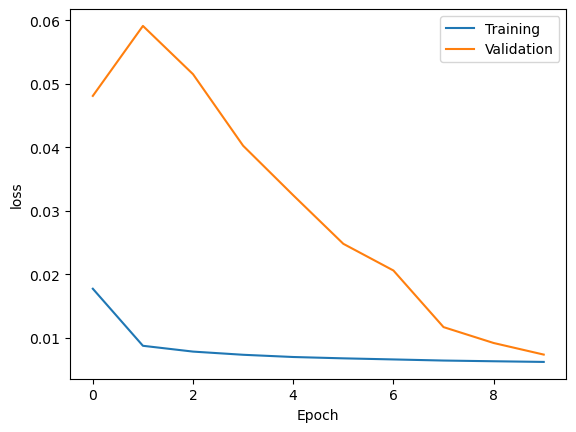

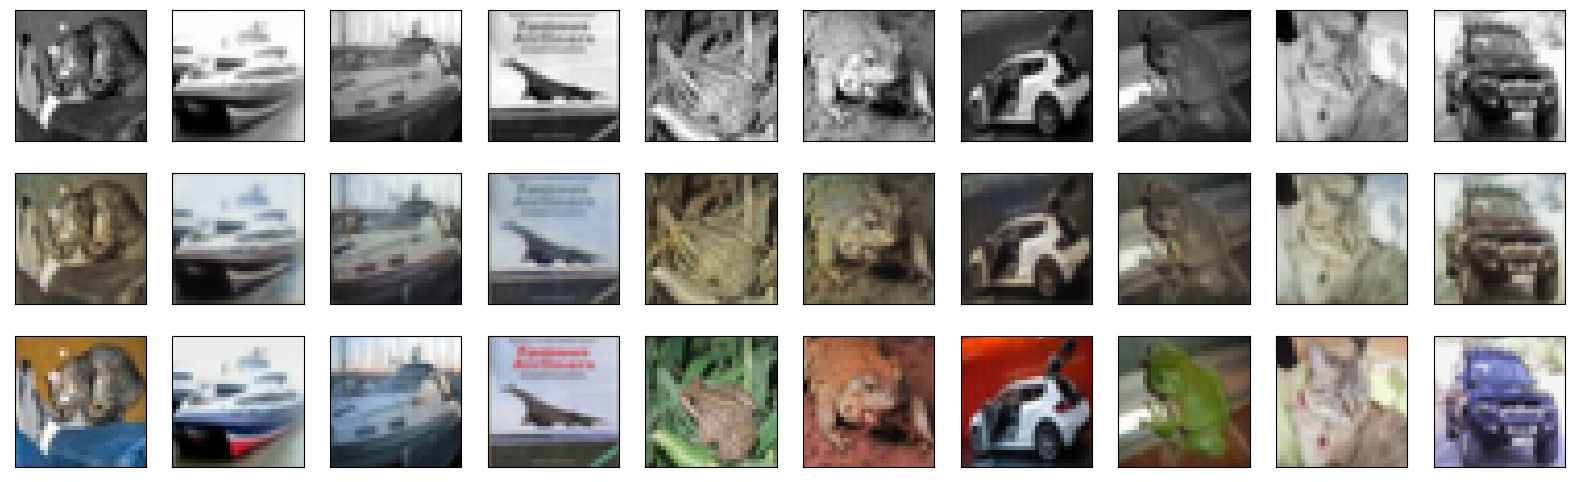

In [30]:
###########################
# 학습 및 확인
###########################    
def main(in_ch=1, epochs=10, batch_size=128, fig=True):


    data = DATA(in_ch=in_ch)
    print(data.input_shape, data.x_train_in.shape)
    unet = UNET(data.input_shape, data.n_ch)

    history = unet.fit(data.x_train_in, data.x_train_out,
                       epochs=epochs,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_split=0.2)

    if fig:
        plot_loss(history)
        show_images(data, unet)


from distutils import util

class parser:
    def __init__(self):
        self.input_channels = 1
        self.epochs = 10
        self.batch_size = 512
        self.fig = True
              
args = parser()
print(args.fig)
main(args.input_channels, args.epochs, args.batch_size, args.fig)